# LELEC2796 - Project
### Authors: Côme Wallner & Jérôme Lafontaine


## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import os

gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
    if(sn.__version__ != '0.15.1'):
        print("WARNING: Sionna version is not 0.15.1, but " + sn.__version__)
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna as sn

print(sn.__version__)

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# For plotting
%matplotlib inline
# also try %matplotlib widget

from sionna.utils import BinarySource, ebnodb2no, compute_ber
from sionna.mapping import Mapper, Demapper


resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass



0.8.0


### Importation of the precomputed channel matrix (Home made **files**)

In [2]:
from Matrices.channel_matrix import h_A, h_B, h_C, h_D
from Matrices.channel_matrix_SISO import h_B_11, h_A_11, h_C_11,h_D_11
from Matrices.channel_matrix_MISO import h_A_21, h_B_21, h_C_21, h_D_21


h_A_21 = np.array([h_A_21])
h_B_21 = np.array([h_B_21])
h_C_21 = np.array([h_C_21])
h_D_21 = np.array([h_D_21])

h_A_11 = np.array([[h_A_11[:,0,:,0,:,:,:]]])
h_B_11 = np.array([[h_B_11[:,0,:,0,:,:,:]]])
h_C_11 = np.array([[h_C_11[:,0,:,0,:,:,:]]])
h_D_11 = np.array([[h_D_11[:,0,:,0,:,:,:]]])


h_A = tf.convert_to_tensor(h_A)
h_B = tf.convert_to_tensor(h_B)
h_C = tf.convert_to_tensor(h_C)
h_D = tf.convert_to_tensor(h_D)

h_A_21 = tf.convert_to_tensor(h_A_21)
h_B_21 = tf.convert_to_tensor(h_B_21)
h_C_21 = tf.convert_to_tensor(h_C_21)
h_D_21 = tf.convert_to_tensor(h_D_21)

h_A_11 = tf.convert_to_tensor(h_A_11)
h_B_11 = tf.convert_to_tensor(h_B_11)
h_C_11 = tf.convert_to_tensor(h_C_11)
h_D_11 = tf.convert_to_tensor(h_D_11)


hs = np.array([h_A,h_B,h_C,h_D])
hs_21 = np.array([h_A_21,h_B_21,h_C_21,h_D_21])
hs_11 = np.array([h_A_11,h_B_11,h_C_11,h_D_11])

tx_position = np.mean([[10.5,21,27],[8.5,21,27]], axis = 0)
rx_A_position = [20.2, 80.3, 1.5]
rx_B_position = [20.7, 82.3, 1.5]
rx_C_position = [90.2, 80.3, 1.5]
rx_D_position = [147.2, 87.3, 1.5]

rx_positions = np.array([rx_A_position, rx_B_position, rx_C_position, rx_D_position])

points = ["A", "B", "C", "D"]

# Genral parameters

In [3]:
####### Position at time 0 (0 = A ; 1 = B ; 2 = C ; 3 = D) #######
First_position = 0
h_start = hs[First_position]
h_start_21 = hs_21[First_position]
h_start_11 = hs_11[First_position]

####### Position at time 1 (0 = A ; 1 = B ; 2 = C ; 3 = D) #######
Second_position = 2
h_end = hs[Second_position]
h_end_21 = hs_21[Second_position]
h_end_11 = hs_11[Second_position]

print("*------------------------------Results--------------------------------*")
print("Distance between the RXs : " + str(np.linalg.norm(rx_positions[First_position] - rx_positions[Second_position])) + " m")
print("Length of the sent signal : ", 2*1/(15e3) , " s |", 2/15, " ms" )
print("The speed should be : " + str(np.linalg.norm(rx_positions[First_position] - rx_positions[Second_position])/(2*1/(15e3))) + " m/s | " + str(np.linalg.norm(rx_positions[First_position]  - rx_positions[Second_position])/(2*1/(15e3))*3.6) + " km/h")
print("*---------------------------------------------------------------------*")



####### Result Folder #######
Folder = "Results/"+points[First_position]+"_"+points[Second_position]+"/"
Frames_spacing = 1/(15e3) #Rate at which the frames in the channel creation must be distant

#################### Parameters ####################
num_bits_per_symbol = 2
batch_size = 1
num_streams_per_tx = 1
num_tx = 2
num_streams_per_rx = 1
num_rx = 2
num_ofdm_symbols = 2  # 10
fft_size = 76
subcarrier_spacing = 15e3
SNR = np.arange(0, 20 , 1)
OFDM_pilots_time = []
averaging_factor = 300
batch_size_channel = 1
####################################################

*------------------------------Results--------------------------------*
Distance between the RXs : 70.0 m
Length of the sent signal :  0.00013333333333333334  s | 0.13333333333333333  ms
The speed should be : 525000.0 m/s | 1890000.0 km/h
*---------------------------------------------------------------------*


# **General parameters**

## Generation of the sent sequence

In [4]:
#Creation of the binary source
binary_source = BinarySource()
#Creation of the mapper (QAM)
mapper = Mapper("qam", num_bits_per_symbol)
#Creation of the sent sequence [batch_size , num_tx , num_streams_per_tx , length]
b_temp = binary_source([1, num_rx, num_streams_per_rx, 64*num_bits_per_symbol*(num_ofdm_symbols-len(OFDM_pilots_time))])

# Antenna 1 and 2 have the same bits
b = np.zeros((1,2,1,64*num_bits_per_symbol*(num_ofdm_symbols-len(OFDM_pilots_time))))
b[0,0,0,:] = b_temp[0,0,0,:]
b[0,1,0,:] = b_temp[0,0,0,:]
#Creation of the symbols x
x = mapper(b).numpy()


## Usefull functions

In [5]:
from utils_Alamouti import BER_th,Alamouti_encoder,OFDM_encoder

0.8.0


# ALAMOUTI

## **ALAMOUTI - OFDM - 1st scheme**

### Creation of the Symbols and OFDM symbols

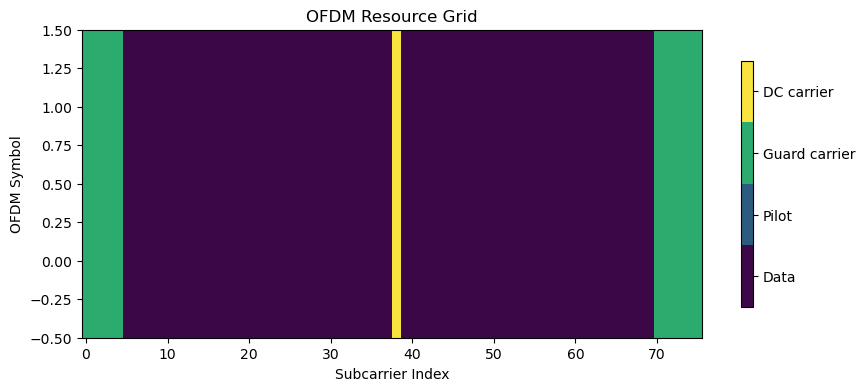

In [6]:
#Generation the Alamouti symbols to send
x_to_send = x[0,0,0,:] * 1/np.sqrt(2) * 1/np.sqrt(2) #Normalization
x_Alamouti = np.zeros_like(x)
x_Alamouti_temp = Alamouti_encoder(x_to_send)
x_Alamouti[0,0,0,:] = x_Alamouti_temp[0,:] 
x_Alamouti[0,1,0,:] = x_Alamouti_temp[1,:]
#OFDM encoding
x_Alamouti_rg ,rg  = OFDM_encoder(x_Alamouti, num_ofdm_symbols, OFDM_pilots_time , display = True)
x_Alamouti_OFDM = x_Alamouti_rg


### Channel

In [7]:
from utils_Alamouti import Alamouti_1_BER_different_SNR

In [8]:
#BER computation with an averaging factor
BER_Alamouti1 = np.zeros(len(SNR))
BER_theo = np.zeros(len(SNR))
averaging = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging):
    BER_Alamouti1[i] += Alamouti_1_BER_different_SNR(x_Alamouti_OFDM , SNR[i], batch_size_channel, rg, h_start,h_end,[],2,2,num_rx=2, num_streams_per_rx=1, b=b)/averaging
  BER_theo[i] = BER_th(10**(SNR[i]/10/2))

## **ALAMOUTI - OFDM - 2nd scheme**

In [9]:
#Generation the Alamouti symbols to send (no Alamouti encoding here, it is done on the OFDM symbols)
x_to_send = x[0,0,0,:]   * 1/np.sqrt(2) * 1/np.sqrt(2) #Power normalization
x_Alamouti2 = np.zeros_like(x)
x_Alamouti2[0,0,0,:] = x_to_send
x_Alamouti2[0,1,0,:] = x_to_send

#OFDM encoding
x_Alamouti_rg_2 ,rg  = OFDM_encoder(x_Alamouti2, num_ofdm_symbols, OFDM_pilots_time , display = False)

x_Alamouti_rg_2 = x_Alamouti_rg_2.numpy()
i = 0
while i < rg.num_ofdm_symbols:
    if (i in OFDM_pilots_time): #if i is a pilot symbol or if i+1 is a pilot symbol i need to do something a little bit different (alamouti on)
        print("pilot")
        i+=1
        continue
    elif i+1 in OFDM_pilots_time:
        print("pilot badly placed")
        s0 = x_Alamouti_rg_2[0,0,0,i,:]
        s1 = x_Alamouti_rg_2[0,0,0,i+2,:]
        x_Alamouti_rg_2[0,0,0,i,:] = s0
        x_Alamouti_rg_2[0,1,0,i,:] = s1
        x_Alamouti_rg_2[0,0,0,i+2,:] = -np.conj(s1)
        x_Alamouti_rg_2[0,1,0,i+2,:] = np.conj(s0)
        i += 3
    else: #Alamouti encoding
        print("Alamouti")
        s0 = x_Alamouti_rg_2[0,0,0,i,:]
        s1 = x_Alamouti_rg_2[0,0,0,i+1,:]
        x_Alamouti_rg_2[0,0,0,i,:] = s0
        x_Alamouti_rg_2[0,1,0,i,:] = s1
        x_Alamouti_rg_2[0,0,0,i+1,:] = -np.conj(s1)
        x_Alamouti_rg_2[0,1,0,i+1,:] = np.conj(s0)
        i += 2

x_Alamouti_2_OFDM = x_Alamouti_rg_2

Alamouti


### Channel

In [10]:
from utils_Alamouti import Alamouti_2_BER_different_SNR

In [11]:
#BER computation with an averaging factor
BER_Alamouti2 = np.zeros(len(SNR))
averaging = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging):
    BER_Alamouti2[i] += Alamouti_2_BER_different_SNR(x_Alamouti_2_OFDM , SNR[i], batch_size_channel,h_start,h_end,2,2,[], rg, b)/averaging

## ALAMOUTI - OFDM - 1st scheme - TX2 - RX1

In [12]:
from utils_TX2_RX1 import Alamouti_1_BER_different_SNR_TX2_RX1

0.8.0


In [13]:
#BER computation with an averaging factor
BER_Alamouti21 = np.zeros(len(SNR))
BER_theo = np.zeros(len(SNR))
averaging = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging):
    BER_Alamouti21[i] += Alamouti_1_BER_different_SNR_TX2_RX1(x_Alamouti_OFDM , SNR[i], batch_size_channel,rg, #We reuse the already computed OFDM symbols from the previous simulation
                                                              h_start_21,h_end_21,b,2,2,[])/averaging
  BER_theo[i] = BER_th(10**(SNR[i]/10/2))

In [14]:
from utils_TX2_RX1 import Alamouti_2_BER_different_SNR_TX2_RX1

In [15]:
BER_Alamouti2_21 = np.zeros(len(SNR))
averaging = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging):
    BER_Alamouti2_21[i] += Alamouti_2_BER_different_SNR_TX2_RX1(x_Alamouti_2_OFDM , SNR[i], batch_size_channel,h_start_21,h_end_21,2,2,[], rg, b)/averaging

## Results ALAMOUTI

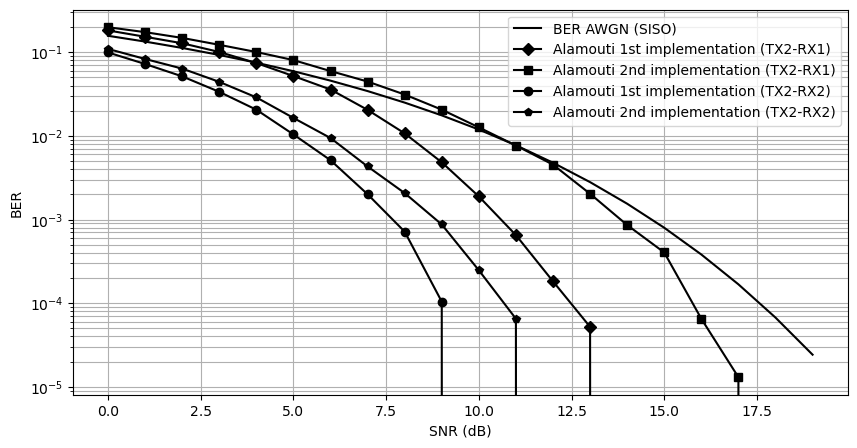

In [16]:
plt.figure(figsize=(10, 5))
plt.semilogy(SNR, BER_theo, '-', label='BER AWGN (SISO)' , color = "black")
plt.semilogy(SNR, BER_Alamouti21, 'D-', label='Alamouti 1st implementation (TX2-RX1)' , color = "black")
plt.semilogy(SNR, BER_Alamouti2_21, 's-', label='Alamouti 2nd implementation (TX2-RX1)' , color = "black")
plt.semilogy(SNR, BER_Alamouti1, 'o-', label='Alamouti 1st implementation (TX2-RX2)' , color = "black")
plt.semilogy(SNR, BER_Alamouti2, 'p-', label='Alamouti 2nd implementation (TX2-RX2)' , color = "black")


plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True , which="both")
plt.legend()
plt.show()

----
# Dominant eigenmode transmission
----

## Dominant Eigenmode transmission TX2-RX2

In [17]:
from utils_eigen import eigen_BER_different_SNR

0.8.0


In [18]:
#Generatation the Dominant eigenmode transmission symbols to send
x_to_send = x[0,0,0,:]   * 1/np.sqrt(2) * 1/np.sqrt(2)
x_eigen = np.zeros_like(x)
x_eigen[0,0,0,:] = x_to_send 
x_eigen[0,1,0,:] = x_to_send
#OFDM encoding
x_eigen_rg ,rg  = OFDM_encoder(x_eigen, num_ofdm_symbols, OFDM_pilots_time , display = False)
x_eigen_OFDM = x_eigen_rg

In [19]:
#BER computation with an averaging factor
BER_eigen = np.zeros(len(SNR))
BER_theo_eigen = np.zeros(len(SNR))
averaging_eigen = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging_eigen):
    BER_eigen[i] += eigen_BER_different_SNR(x_eigen_OFDM , SNR[i], 1, rg,[], 2,2, h_start, h_end, b)/averaging_eigen
  BER_theo[i] = BER_th(10**(SNR[i]/10/2))


## Comparison - DET vs Alamouti

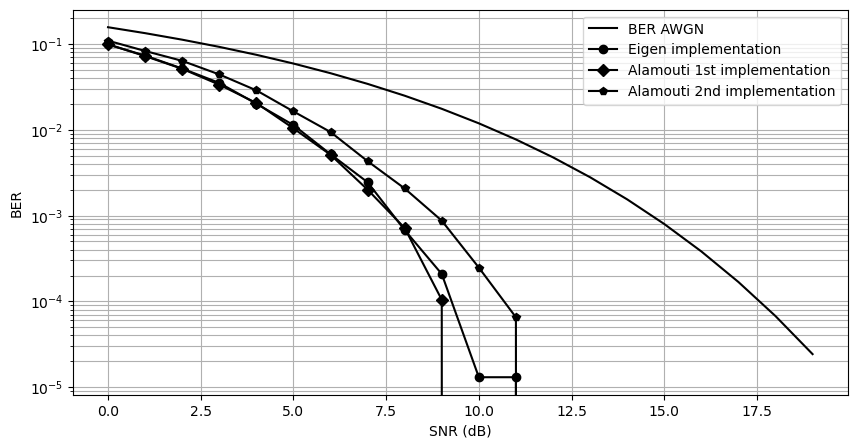

In [20]:
plt.figure(figsize=(10, 5))
plt.semilogy(SNR, BER_theo, '-', label='BER AWGN' , color = "black")
plt.semilogy(SNR, BER_eigen, 'o-', label='Eigen implementation' , color = "black")

plt.semilogy(SNR, BER_Alamouti1, 'D-', label='Alamouti 1st implementation' , color = "black")
plt.semilogy(SNR, BER_Alamouti2, 'p-', label='Alamouti 2nd implementation' , color = "black")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True , which="both")
plt.legend()
plt.show()

## Dominant Eigenmode transmission TX2-RX1

In [21]:
from utils_eigen_TX2_RX1 import eigen_BER_different_SNR_TX2_RX1

0.8.0


In [22]:
# BER computation with an averaging factor
BER_eigen21 = np.zeros(len(SNR))
BER_theo_eigen = np.zeros(len(SNR))
averaging_eigen = averaging_factor
for i in range(len(SNR)):
  for j in range(averaging_eigen):
    BER_eigen21[i] += eigen_BER_different_SNR_TX2_RX1(x_eigen_OFDM , SNR[i], 1,rg,h_start_21,h_end_21,b,[],2,2)/averaging_eigen
  BER_theo[i] = BER_th(10**(SNR[i]/10/2))

## Results DET - TX2 - RX1/2

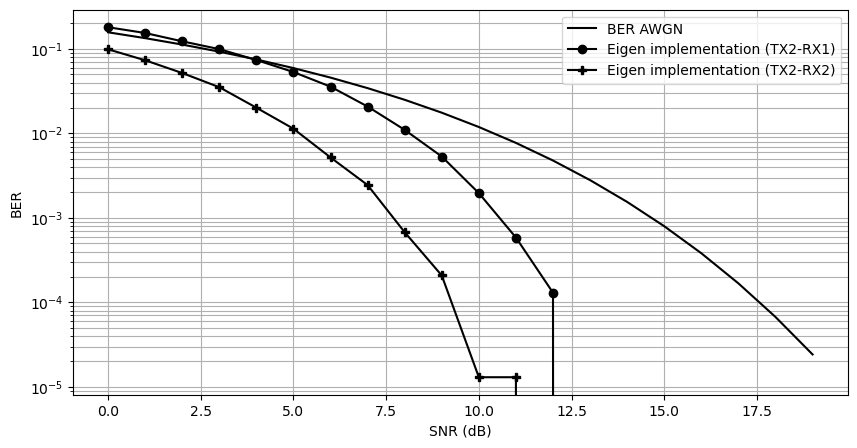

In [23]:
plt.figure(figsize=(10, 5))
plt.semilogy(SNR, BER_theo, '-', label='BER AWGN' , color = "black")
plt.semilogy(SNR, BER_eigen21, 'o-', label='Eigen implementation (TX2-RX1)' , color = "black")
plt.semilogy(SNR, BER_eigen, 'P-', label='Eigen implementation (TX2-RX2)' , color = "black")

plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True , which="both")
plt.legend()
plt.show()

# Summary of results

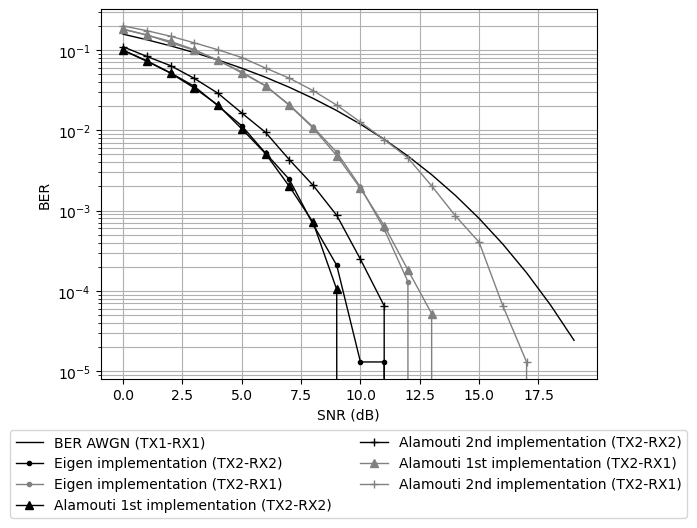

In [24]:
from cycler import cycler

monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['x', '+','.','^']))
linewidth_size = 1

fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
ax.semilogy(SNR, BER_theo,'-', label='BER AWGN (TX1-RX1)' , linewidth = linewidth_size)
ax.semilogy(SNR, BER_eigen, '.-', label='Eigen implementation (TX2-RX2)' , linewidth = linewidth_size)
plt.semilogy(SNR, BER_eigen21, '.-', label='Eigen implementation (TX2-RX1)' , color = "grey", linewidth = linewidth_size)

ax.semilogy(SNR, BER_Alamouti1, '^-',label='Alamouti 1st implementation (TX2-RX2)' , linewidth = linewidth_size)
ax.semilogy(SNR, BER_Alamouti2, '+-',label='Alamouti 2nd implementation (TX2-RX2)' , linewidth = linewidth_size)
plt.semilogy(SNR, BER_Alamouti21, '^-', label='Alamouti 1st implementation (TX2-RX1)' , color = "grey", linewidth = linewidth_size)
plt.semilogy(SNR, BER_Alamouti2_21, '+-', label='Alamouti 2nd implementation (TX2-RX1)' , color = "grey", linewidth = linewidth_size)


ax.set_xlabel('SNR (dB)')
ax.set_ylabel('BER')
ax.grid(True , which="both")
lgd = ax.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=2)
plt.savefig(Folder + "Alam_eigen.svg",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#save all the results in a csv file in order to plot them later
data = np.array([SNR, BER_theo, BER_eigen, BER_eigen21, BER_Alamouti1, BER_Alamouti2, BER_Alamouti21, BER_Alamouti2_21])
data = np.transpose(data)
df = pd.DataFrame(data, columns=["SNR", "BER_theo", "BER_eigen", "BER_eigen21", "BER_Alamouti1", "BER_Alamouti2", "BER_Alamouti21", "BER_Alamouti2_21"])
df.to_csv(Folder + "results.csv")
